In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(
    font_scale = 2,
    style='whitegrid',
    rc={'figure.figsize' : (20,7)}
)

# Анализ рекламных объявлений

In [6]:
ads_data = pd.read_csv(ads_data, parse_dates=['date', 'time'])
ads_clients_data = pd.read_csv(ads_clients_data, parse_dates=['date', 'create_date'])

### Описание данных
**`ads_data.csv`** – данные взаимодействий с рекламными объявлениями

**date** – дата <br>
**time** – время <br>
**event** – действие (просмотр/клик) <br>
**platform** – платформа <br>
**ad_id** – id объявления <br>
**client_union_id** – id рекламного кабинета <br>
**campaign_union_id** – id рекламной кампании <br>
**ad_cost_type** – тип оплаты <br>
**ad_cost** – цена <br>
**has_video** – есть ли видео <br>
**target_audience_count** – размер аудитории<br>

**`ads_clients_data.csv`** – характеристики рекламных клиентов<br>
**date** – дата<br>
**client_union_id** – id рекламного кабинета<br>
**community_id** – id сообщества<br>
**create_date** – дата создания рекламного клиента

In [7]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [20]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


**1. Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям**

In [29]:
#некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, поэтому заполняем значения 
ads_data.groupby(['ad_id', 'event'], as_index=False)\
    .agg({'platform':'count'})\
    .pivot(index='ad_id', columns='event', values='platform')\
    .fillna(0)\
    .mean()\
    .round()

event
click    113.0
view     923.0
dtype: float64

**Вывод** <br>
Среднее количество кликов на объявление 113 <br>
Среднее количество показов на объявление 923


**2. Посмотрим на распределение показов объявлений**

In [33]:
views = ads_data.groupby(['event', 'ad_id'], as_index=False)\
    .agg({'platform':'count'})\
    .query("event == 'view'")
views['log_v'] = np.log(views.platform)

<AxesSubplot:xlabel='log_v', ylabel='Density'>

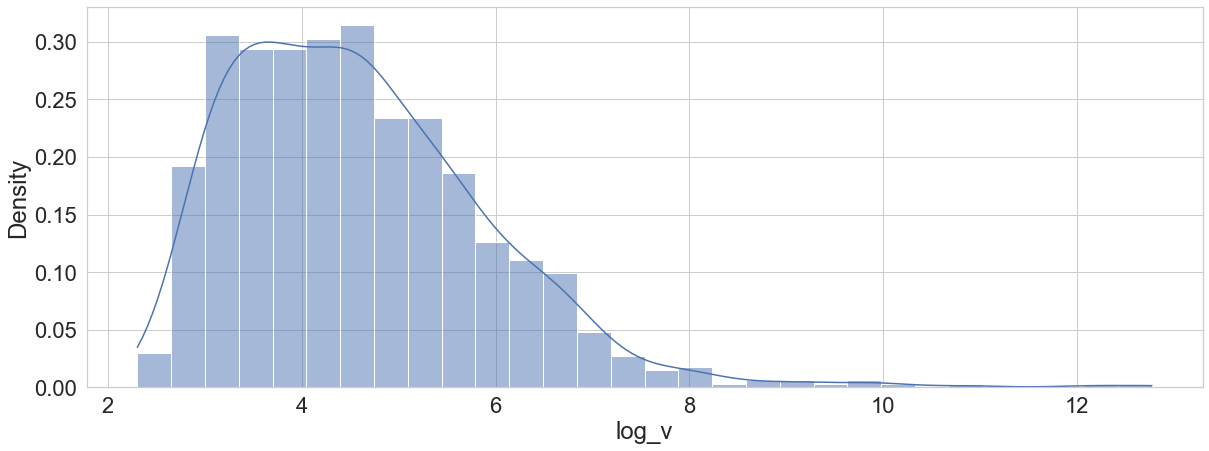

In [57]:
sns.histplot(views.log_v, stat="density", kde=True)

**3. Найдем среднее количество показов на 1 объявление по дням**, не учитывая объявления, у которых не было показов

In [66]:
views1 = ads_data.query("event == 'view'")\
    .pivot_table(index='ad_id',
                columns='date',
                values='time',
                aggfunc='count')

In [69]:
mean_views = views1.mean()

In [80]:
#посчитаеv скользящее среднее по полученному результату с окном в 2 элемента
roll_mean = mean_views.rolling(2).mean().round(2)

In [81]:
roll_mean

date
2019-04-01       NaN
2019-04-02    146.13
2019-04-03    150.87
2019-04-04    419.93
2019-04-05    797.51
2019-04-06    598.12
dtype: float64

**4. Поиск аномального дня по графику**

Скользящее среднее часто используется для поиска аномалий в данных. Попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных 

<AxesSubplot:xlabel='date'>

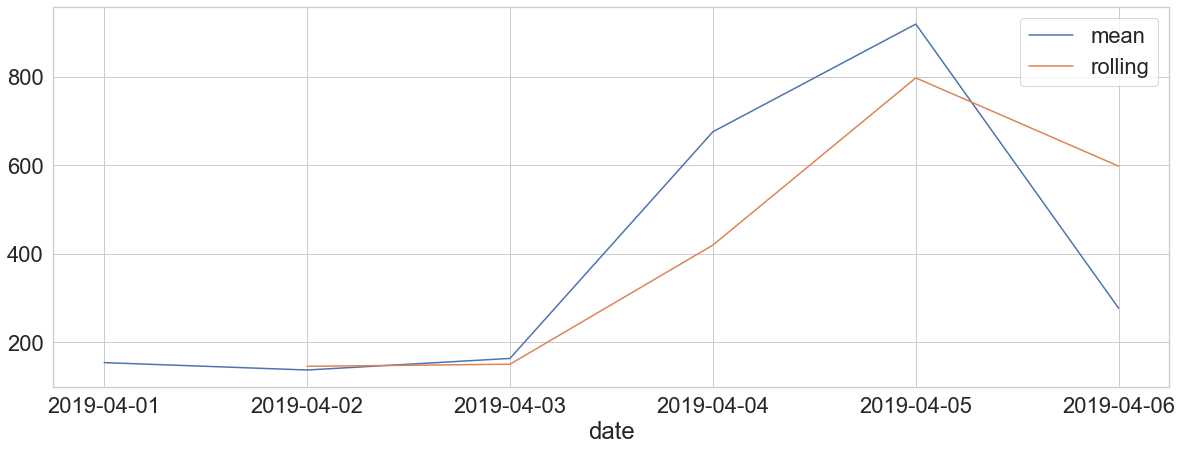

In [84]:
sns.lineplot(data=mean_views, label='mean')
sns.lineplot(data=roll_mean, label='rolling')

In [89]:
abs(mean_views - roll_mean).idxmax()

Timestamp('2019-04-06 00:00:00')

**Вывод** <br>
Наибольшая разница по модулю между арифметическим средним и скользящим средним

**5. Найдем среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date)**

In [102]:
#Объединяем данные рекламы с данными о рекламных клиентах
ads_full = ads_data.merge(ads_clients_data.drop(columns=['date','community_id']))

In [103]:
ads_full.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [109]:
ads_dif = ads_full.groupby('client_union_id')\
    .apply(lambda group:(group.date - group.create_date).min())
ads_dif.head()

client_union_id
1     98 days
9    114 days
13    66 days
16   105 days
20    32 days
dtype: timedelta64[ns]

In [110]:
ads_dif.mean()

Timedelta('124 days 09:04:43.532219570')

**Вывод** <br>
Cреднее число дней между датой создания объявления и первым запуском == 124 дня

**6. Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней**

In [115]:
ads_full['date_since'] = ads_full.date - ads_full.create_date

In [124]:
#Считаем число клиентов, которые совершили целевое действие (создали рекламу)
a = ads_full.groupby('client_union_id', as_index=False)\
    .agg({'date_since' : 'count'})\
    .shape[0]

#Считаем общее число клиентов 
b = ads_clients_data.groupby('client_union_id').agg({'create_date':'count'}).shape[0]

In [125]:
c = round((a/b*100),2) #считаем конверсию

**Вывод**

In [126]:
print('Конверсия из создания рекламного кабинета в запуск первой рекламы:',c)

Конверсия из создания рекламного кабинета в запуск первой рекламы: 0.69


**7. Посмотрим, сколько уникальных клиентов запустили свое первое объявление в различные промежутки дней**

In [129]:
sd = ads_full.groupby('client_union_id', as_index=False)\
    .agg({'date_since' : 'min'})
sd['date_since1'] = pd.cut(sd.date_since, bins = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']))

**Промежутки**
1. 0-30 дней
2. 30-90 дней
3. 90-180 дней
4. 180-365 дней

In [130]:
sd.groupby(['date_since1']).agg({'client_union_id':'count'})

,client_union_id
date_since1,
"(0 days 00:00:00, 30 days 00:00:00]",11
"(30 days 00:00:00, 90 days 00:00:00]",263
"(90 days 00:00:00, 180 days 00:00:00]",396
"(180 days 00:00:00, 365 days 00:00:00]",168
